# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dip

In [2]:
%matplotlib notebook

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Find the best "dippers"

In [5]:
# Load a small catalog where we have used loose selection cuts
# to find dippers.
wtf = catalog.load('wtf_full_oct19_4')

In [6]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    .drop('dip')
    .select(
        '*',
        dip.build_analyze_dip_udf(max_gap=2.)(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r']
        ).alias('dip'),
    )
)

In [7]:
%%time

# Get the best dippers
best_dippers = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).head(1000)

CPU times: user 386 ms, sys: 195 ms, total: 581 ms
Wall time: 36.7 s


RA+Dec: 326.513452+46.911057

Dip details:
intmag     : 3.367558479309082
start_mjd  : 58430.12890625
end_mjd    : 58441.28515625
nobs       : 22
complexity : 0.9940018653869629
significance: 169.41009521484375
num_dips   : 5


<IPython.core.display.Javascript object>


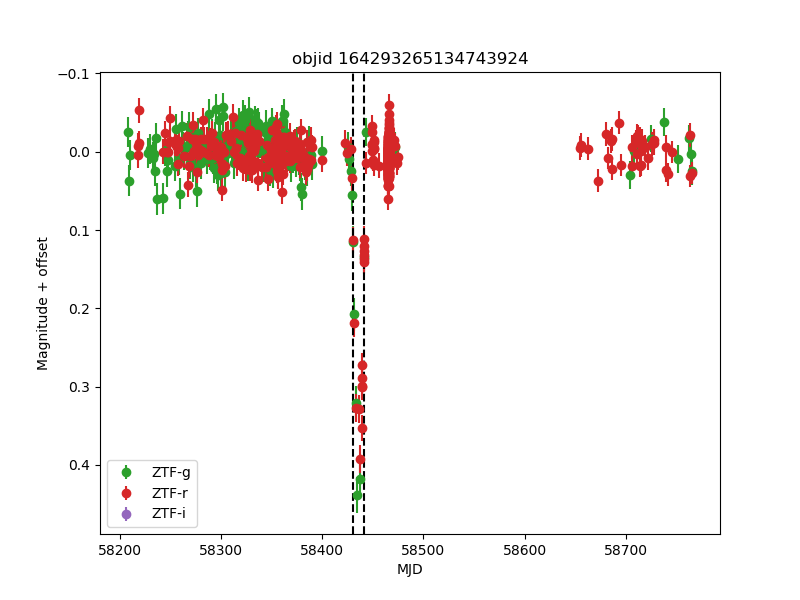

In [8]:
# Plot a light curve
dip.plot_light_curve(best_dippers[5])

In [9]:
# Show an interactive display of the light curves
dip.plot_interactive(best_dippers)

interactive(children=(IntSlider(value=0, description='idx', max=999), Checkbox(value=True, description='parsed'), Checkbox(value=True, description='label_dip'), Checkbox(value=False, description='zoom'), Checkbox(value=True, description='verbose'), Output()), _dom_classes=('widget-interact',))

# Rerun over the full ZTF dataset

Warning! This takes a long time to run. It is recommended to increase the number of cores that spark is running on before you execute this (e.g, in the spark setup change `.config('spark.master', "local[6]")` which uses 6 cores to something larger. When running on 32 cores, this runs on epyc in ~10 hours. 

In [35]:
# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

In [ ]:
%%time

# Run the dip detection query on the full ZTF dataset on spark
result = (
    ztf
    .exclude_duplicates()
    #.region(ra1=295, ra2=296, dec1=20, dec2=21)
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
    .select(
        '*',
        dip.build_analyze_dip_udf(max_gap=2.)(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significance") > 10.)
    )
    .write.parquet('./query_wtf.parquet')
)

In [ ]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('./query_wtf.parquet')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_4', repartition=True)